Version 1.0.0

# Introduction

In this programming assignment we will illustrate a very severe data leakage, that can often be found in competitions, where the pairs of object should be scored, e.g. predict $1$ if two objects belong to the same class and $0$ otherwise. 

The data in this assignment is taken from a real competition, and the funniest thing is that *we will not use training set at all* and achieve almost 100% accuracy score! We will just exploit the leakage.

Now go through the notebook and complete the assignment.

In [1]:
import numpy as np
import pandas as pd 
import scipy.sparse

import matplotlib.pyplot as plt
import scipy.sparse as sparse
%matplotlib inline


# Load the data

Let's load the test data. Note, that we don't have any training data here, just test data. Moreover, *we will not even use any features* of test objects. All we need to solve this task is the file with the indices for the pairs, that we need to compare.

Let's load the data with test indices.

In [2]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


For example, we can think that there is a test dataset of images, and each image is assigned a unique `Id` from $0$ to $N-1$ (N -- is the number of images). In the dataframe from above `FirstId` and `SecondId` point to these `Id`'s and define pairs, that we should compare: e.g. do both images in the pair belong to the same class or not. So, for example for the first row: if images with `Id=1427` and `Id=8053` belong to the same class, we should predict $1$, and $0$ otherwise. 

But in our case we don't really care about the images, and how exactly we compare the images (as long as comparator is binary).  

**We suggest you to try to solve the puzzle yourself first.** You need to submit a `.csv` file with columns `pairId` and `Prediction` to the grader. The number of submissions allowed is made pretty huge to let you explore the data without worries. The returned score should be very close to $1$.

**If you do not want to think much** -- scroll down and follow the instructions below.

In [3]:
test.shape

(368550, 3)

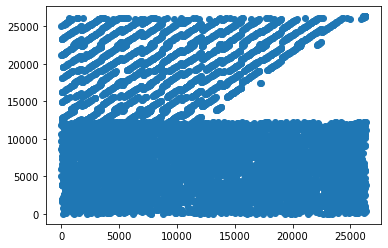

In [4]:
plt.scatter(test.FirstId.iloc[0:10000], test.SecondId.iloc[0:10000])

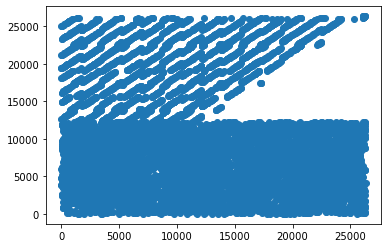

In [5]:
plt.scatter(test.FirstId.iloc[10000:20000], test.SecondId.iloc[10000:20000])

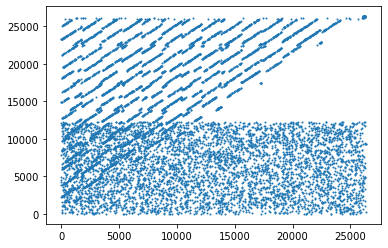

In [6]:
plt.scatter(test.FirstId.iloc[350000:360000], test.SecondId.iloc[350000:360000], 1)

# EDA and leakage intuition

As we already know, the key to discover data leakages is careful EDA. So let's start our work with some basic data exploration and build an intuition about the leakage.

First, check, how many different `id`s are there: concatenate `FirstId` and `SecondId` and print the number of unique elements. Also print minimum and maximum value for that vector.

In [7]:
# YOUR CODE GOES HERE
print (test.FirstId.nunique())
print (test.FirstId.min())
print (test.FirstId.max())


print (test.SecondId.nunique())
print (test.SecondId.min())
print (test.SecondId.max())

26325
0
26324
26310
0
26324


and then print how many pairs we need to classify (it is basically the number of rows in the test set)

In [8]:
# YOUR CODE GOES HERE
print(len(test))

368550


Now print, how many distinct pairs it would be possible to create out of all "images" in the dataset?   

In [9]:
# YOUR CODE GOES HERE
print(test.FirstId.nunique() * (test.SecondId.nunique()-1)/2)

print(test.FirstId.nunique() * (test.SecondId.nunique()-1)/2/len(test))

346292212.5
939.6071428571429


So the number of pairs we are given to classify is very very small compared to the total number of pairs. 

To exploit the leak we need to **assume (or prove)**, that the total number of positive pairs is small, compared to the total number of pairs. For example: think about an image dataset with $1000$ classes, $N$ images per class. Then if the task was to tell whether a pair of images belongs to the same class or not, we would have $1000\frac{N(N-1)}{2}$ positive pairs, while total number of pairs was $\frac{1000N(1000N - 1)}{2}$.

Another example: in [Quora competitition](https://www.kaggle.com/c/quora-question-pairs) the task was to classify whether a pair of qustions are duplicates of each other or not. Of course, total number of question pairs is very huge, while number of duplicates (positive pairs) is much much smaller.

Finally, let's get a fraction of pairs of class `1`. We just need to submit a constant prediction "all ones" and check the returned accuracy. Create a dataframe with columns `pairId` and `Prediction`, fill it and export it to `.csv` file. Then submit to grader and examine grader's output. 

In [10]:
# YOUR CODE GOES HERE
all1=test[['pairId']]

In [11]:
all1['Prediction'] = 1

<ipython-input-11-0d1c293ac051>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all1['Prediction'] = 1


In [12]:
all1.head()

,pairId,Prediction
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [13]:
all1.to_csv('all1.csv', index=False)

So, we assumed the total number of pairs is much higher than the number of positive pairs, but it is not the case for the test set. It means that the test set is constructed not by sampling random pairs, but with a specific sampling algorithm. Pairs of class `1` are oversampled.

Now think, how we can exploit this fact? What is the leak here? If you get it now, you may try to get to the final answer yourself, othewise you can follow the instructions below.   

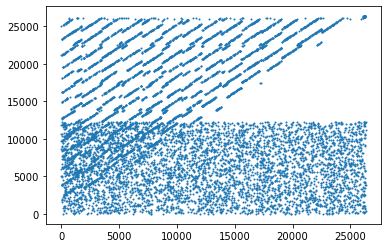

In [14]:
plt.scatter(test.FirstId.iloc[0:10000], test.SecondId.iloc[0:10000], 1)

# Building a magic feature

In this section we will build a magic feature, that will solve the problem almost perfectly. The instructions will lead you to the correct solution, but please, try to explain the purpose of the steps we do to yourself -- it is very important.

## Incidence matrix

First, we need to build an [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix). You can think of pairs `(FirstId, SecondId)` as of edges in an undirected graph. 

The incidence matrix is a matrix of size `(maxId + 1, maxId + 1)`, where each row (column) `i` corresponds `i-th` `Id`. In this matrix we put the value `1` to the position `[i, j]`, if and only if a pair `(i, j)` or `(j, i)` is present in  a given set of pais `(FirstId, SecondId)`. All the other elements in the incidence matrix are zeros.   

**Important!** The incidence matrices are typically very very sparse (small number of non-zero values). At the same time incidence matrices are usually huge in terms of total number of elements, and it is **impossible to store them in memory in dense format**. But due to their sparsity incidence matrices **can be easily represented as sparse matrices**. If you are not familiar with sparse matrices, please see [wiki](https://en.wikipedia.org/wiki/Sparse_matrix) and [scipy.sparse reference](https://docs.scipy.org/doc/scipy/reference/sparse.html). Please, use any of `scipy.sparse` constructors to build incidence matrix. 

For example, you can use this constructor: `scipy.sparse.coo_matrix((data, (i, j)))`. We highly recommend to learn to use different `scipy.sparse` constuctors, and matrices types, but if you feel you don't want to use them, you can always build this matrix with a simple `for` loop. You will need first to create a matrix using `scipy.sparse.coo_matrix((M, N), [dtype])` with an appropriate shape `(M, N)` and then iterate through `(FirstId, SecondId)` pairs and fill corresponding elements in matrix with ones. 

**Note**, that the matrix should be symmetric and consist only of zeros and ones. It is a way to check yourself.

In [15]:
print(len(np.array(test.pairId)))
print(len(np.array(test.FirstId)))
print(len(np.array(test.SecondId)))
print(len(test.pairId))

print (test.FirstId.nunique())
print (test.FirstId.min())
print (test.FirstId.max())


print (test.SecondId.nunique())
print (test.SecondId.min())
print (test.SecondId.max())

368550
368550
368550
368550
26325
0
26324
26310
0
26324


In [16]:
r = pd.concat([test.FirstId, test.SecondId])
c = pd.concat([test.SecondId, test.FirstId])
p = np.empty(len(r)); p[:]=1


In [17]:
#m = scipy.sparse.coo_matrix((np.array(test.pairId), (np.array(test.FirstId), np.array(test.SecondId))))
m = scipy.sparse.coo_matrix((p, (r, c)))

# conver to 0 or 1, ignoreing duplicates
m = m.astype(bool).astype(int)

print(m.max())

1


In [18]:
inc_mat = m # YOUR CODE GOES HERE (but probably you will need to write few more lines before)

# Sanity checks
assert inc_mat.max() == 1
assert inc_mat.sum() == 736872

In [19]:
# ALTERNATIVE USING FOR LOOP

#m1 = scipy.sparse.dok_matrix((test.FirstId.max()+1, test.SecondId.max()+1))
#for i in range(0, len(test)):
#    x = test.FirstId[i]
#    y = test.SecondId[i]
#    m1[x, y] = 1
#    m1[y, x] = 1
#
#print(m1.shape)
#
#inc_mat = m1 # YOUR CODE GOES HERE (but probably you will need to write few more lines before)
#
## Sanity checks
##assert inc_mat.maximum() == 1
#assert inc_mat.sum() == 736872

It is convenient to have matrix in `csr` format eventually.

In [20]:
inc_mat = inc_mat.tocsr()

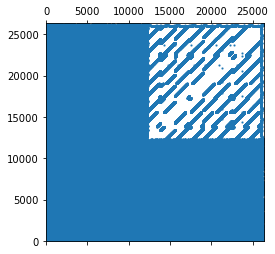

In [21]:
plt.spy(inc_mat, origin='lower', markersize=1, precision=0.1)
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## Now build the magic feature

Why did we build the incidence matrix? We can think of the rows in this matix as of representations for the objects. `i-th` row is a representation for an object with `Id = i`. Then, to measure similarity between two objects we can measure similarity between their representations. And we will see, that such representations are very good.

Now select the rows from the incidence matrix, that correspond to `test.FirstId`'s, and `test.SecondId`'s.

In [22]:
# Note, scipy goes crazy if a matrix is indexed with pandas' series. 
# So do not forget to convert `pd.series` to `np.array`
# These lines should normally run very quickly 

rows_FirstId   = np.array(test.FirstId) # YOUR CODE GOES HERE
rows_SecondId  = np.array(test.SecondId) # YOUR CODE GOES HERE

In [23]:
print(rows_FirstId.shape)
print(rows_SecondId.shape)

(368550,)
(368550,)


Our magic feature will be the *dot product* between representations of a pair of objects. Dot product can be regarded as similarity measure -- for our non-negative representations the dot product is close to 0 when the representations are different, and is huge, when representations are similar. 

Now compute dot product between corresponding rows in `rows_FirstId` and `rows_SecondId` matrices.

In [24]:
inc_mat[[1427,23000]].toarray().shape

(2, 26325)

In [25]:
inc_mat.shape

(26325, 26325)

In [26]:
inc_mat[rows_FirstId].shape

(368550, 26325)

In [27]:
inc_mat[rows_SecondId].shape

(368550, 26325)

In [28]:
inc_mat[rows_FirstId].multiply(inc_mat[rows_SecondId])[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [29]:
f = inc_mat[rows_FirstId].multiply(inc_mat[rows_SecondId])# YOUR CODE GOES HERE

In [30]:
f.shape

(368550, 26325)

In [31]:
f = f.sum(axis=1).getA1()

In [32]:
# Note, that in order to do pointwise multiplication in
# scipy.sparse you need to use function `multiply`
# regular `*` corresponds to matrix-matrix multiplication



# Sanity check
assert f.shape == (368550, )

In [33]:
print(f)

[20 14 20 ... 14 14 14]


In [34]:
np.asarray(np.unique(f, return_counts=True)).T

array([[    14, 183279],
       [    15,    852],
       [    19,    546],
       [    20, 183799],
       [    21,      6],
       [    28,     54],
       [    35,     14]])

(array([1.84131e+05, 5.46000e+02, 1.83805e+05, 0.00000e+00, 5.40000e+01,
        0.00000e+00, 1.40000e+01]),
 array([14., 17., 20., 23., 26., 29., 32., 35.]),
 <a list of 7 Patch objects>)

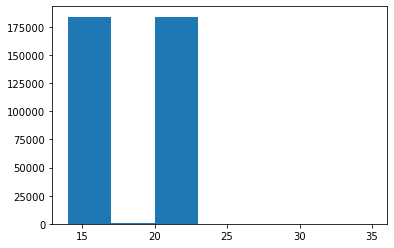

In [35]:
plt.hist(f, bins=7)

That is it! **We've built our magic feature.** 

# From magic feature to binary predictions

But how do we convert this feature into binary predictions? We do not have a train set to learn a model, but we have a piece of information about test set: the baseline accuracy score that you got, when submitting constant. And we also have a very strong considerations about the data generative process, so probably we will be fine even without a training set. 

We may try to choose a thresold, and set the predictions to 1, if the feature value `f` is higer than the threshold, and 0 otherwise. What threshold would you choose? 

How do we find a right threshold? Let's first examine this feature: print frequencies (or counts) of each value in the feature `f`.

In [36]:
# For example use `np.unique` function, check for flags
up = np.asarray(np.unique(f, return_counts=True))
up.T

array([[    14, 183279],
       [    15,    852],
       [    19,    546],
       [    20, 183799],
       [    21,      6],
       [    28,     54],
       [    35,     14]])

Do you see how this feature clusters the pairs? Maybe you can guess a good threshold by looking at the values? 

In fact, in other situations it can be not that obvious, but in general to pick a threshold you only need to remember the score of your baseline submission and use this information. Do you understand why and how?  

Choose a threshold below: 

In [37]:
# Well done! Your accuracy score is 0.998128 

#pred = f > 19 # SET THRESHOLD HERE

In [38]:
# Well done! Your accuracy score is 0.999734 

pred = (f == 20) | (f == 19)

# Finally, let's create a submission

In [39]:
submission = test.loc[:,['pairId']]
submission['Prediction'] = pred.astype(int)

submission.to_csv('submission2.csv', index=False)

Now submit it to the grader! It is not possible to submit directly from this notebook, as we need to submit a `csv` file, not a single number (limitation of Coursera platform). 

To download `submission.csv` file that you've just produced <a href='./submission.csv'>click here</a> (if the link opens in browser, right-click on it and shoose "Save link as"). Then go to [assignment page](https://www.coursera.org/learn/competitive-data-science/programming/KsASv/data-leakages/submission) and submit your `.csv` file in 'My submission' tab.


If you did everything right, the score should be very high.

**Finally:** try to explain to yourself, why the whole thing worked out. In fact, there is no magic in this feature, and the idea to use rows in the incidence matrix can be intuitively justified.

# Bonus

Interestingly, it is not the only leak in this dataset. There is another totally different way to get almost 100% accuracy. Try to find it!

## Try 1 - removing outliers

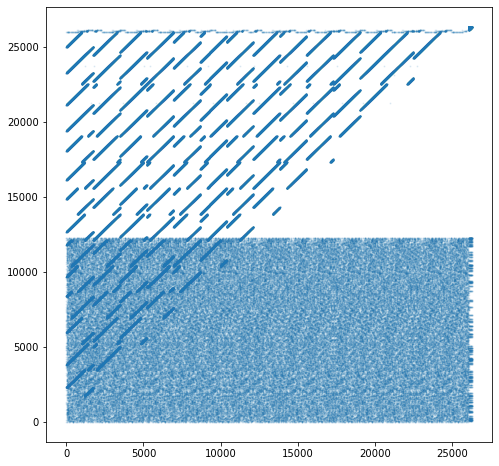

In [40]:
f, ax = plt.subplots(figsize=(8, 8))

plt.scatter(test['FirstId'], test['SecondId'], s=1, alpha=0.1)
plt.show()

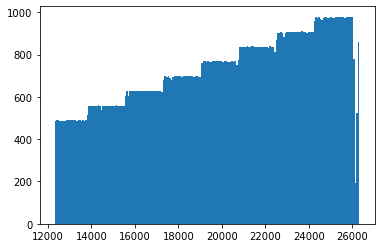

In [41]:
plt.hist(test['SecondId'].loc[test.SecondId>12323], bins=200)
plt.show()

In [42]:
from sklearn.neighbors import LocalOutlierFactor

train1 = test[['FirstId', 'SecondId']].loc[(test.FirstId < test.SecondId)]

# 0.1020
#f = LocalOutlierFactor(novelty=True)
# 0.0737
#f = LocalOutlierFactor(n_neighbors = 20, p = 3, algorithm='auto', contamination=0.5, novelty=True)
# 0.0727
#f = LocalOutlierFactor(n_neighbors = 20, p = 10, algorithm='auto', contamination=0.5, novelty=True)
# 0.0152
#f = LocalOutlierFactor(n_neighbors = 10, p = 10, algorithm='auto', contamination=0.5, novelty=True)
# 0.0119
#f = LocalOutlierFactor(n_neighbors = 10, p = 1, algorithm='auto', contamination=0.5, novelty=True)
# 0.0019
#f = LocalOutlierFactor(n_neighbors = 8, p = 1, algorithm='auto', contamination=0.5, novelty=True)
# 

f1 = LocalOutlierFactor(n_neighbors = 8, p = 1, algorithm='auto', contamination=0.5, novelty=True)
model1 = f1.fit(train1)

#f2 = LocalOutlierFactor(n_neighbors = 20, p = 2, algorithm='auto', contamination=0.45, novelty=True)
#model2 = f2.fit(train2)

p1 = model1.predict(test[['FirstId', 'SecondId']]) > 0
#p2 = model2.predict(test[['FirstId', 'SecondId']])

magic2 = (p1).astype(bool)

print(magic2.sum()/test.shape[0])
print("magic vs magic2", np.sqrt(np.mean(pred.astype('int')-magic2.astype('int'))**2))

0.5011748745082079
magic vs magic2 0.000984940984940985


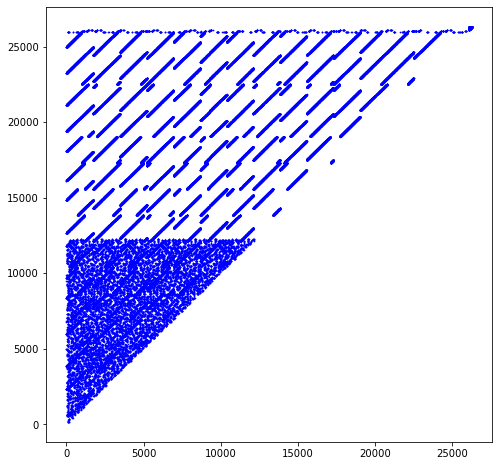

In [43]:
f, ax = plt.subplots(figsize=(8, 8))

condm2 = (magic2)

plt.scatter(test['FirstId' ].loc[condm2],
            test['SecondId'].loc[condm2], s=0.5, c="blue")

plt.show()

In [44]:
submission_bonus = pd.DataFrame(
    {
        "pairId": test.pairId,
        "Prediction": magic2.astype(int),
    })

assert(submission_bonus.shape[0] == test.shape[0])
assert(submission_bonus.Prediction.dtype == 'int')


submission_bonus.to_csv('submission_bonus.csv', index=False)

In [45]:
# got 0.908021

## Try 2

So, when you see the scatter plot of FirstId and SecondId, there is a pattern and a large noise at the half of the bottom. Let's take a deeper look at some part if we can find any pattern we can use.

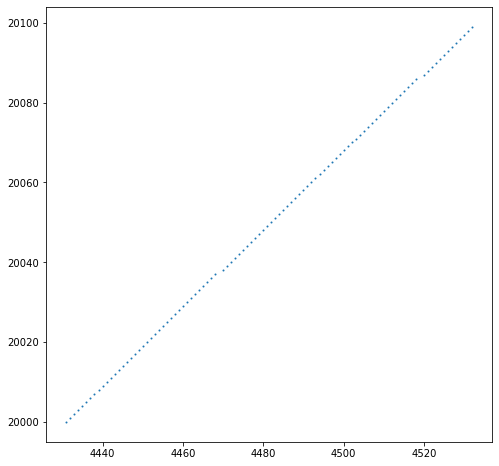

In [46]:
f, ax = plt.subplots(figsize=(8, 8))

cond = (test.FirstId  >= 4000) & (test.FirstId  < 5000) & (test.SecondId >= 20000) & (test.SecondId < 20100)

plt.scatter(test['FirstId' ].loc[cond],
            test['SecondId'].loc[cond], s=1) #, alpha=0.1)
plt.show()

Seems like there is a 45' line but not connected sometimes. Let's take a look at another part, which is the right-upper corner:

In [47]:
test.loc[cond].sort_values(by=['FirstId']).loc[test.FirstId > 4460].head(20)

,pairId,FirstId,SecondId
358390,358390,4461,20030
12896,12896,4462,20031
183820,183820,4463,20032
308857,308857,4464,20033
137526,137526,4465,20034
225994,225994,4466,20035
170446,170446,4467,20036
134843,134843,4468,20037
195565,195565,4470,20038
301900,301900,4471,20039


From above, we can see that when FirstId = X and SecondId = Y, there is FirstId = X + 1 and SecondId = Y + 1. Let's try to build a magic feature using this property.

In [48]:
test3 = test.copy()
test3["magic3"] = 0

i = 0
for index, row in test.iterrows():
    rnext = test.loc[(test.FirstId == row.FirstId + 1) & (test.SecondId == row.SecondId + 1)]
    rprev = test.loc[(test.FirstId == row.FirstId - 1) & (test.SecondId == row.SecondId - 1)]
    
    test3.at[index, "magic3"] = 0 if rnext.empty and rprev.empty else 1

    if i % (test.shape[0]/10) == 0:
        print("%.2f %% completed" % (i/test.shape[0] * 100))
    i += 1
        
        
print("done.")

test3.head()

0.00 % completed
10.00 % completed
20.00 % completed
30.00 % completed
40.00 % completed
50.00 % completed
60.00 % completed
70.00 % completed
80.00 % completed
90.00 % completed
done.


,pairId,FirstId,SecondId,magic3
0,0,1427,8053,1
1,1,17044,7681,0
2,2,19237,20966,1
3,3,8005,20765,1
4,4,16837,599,0


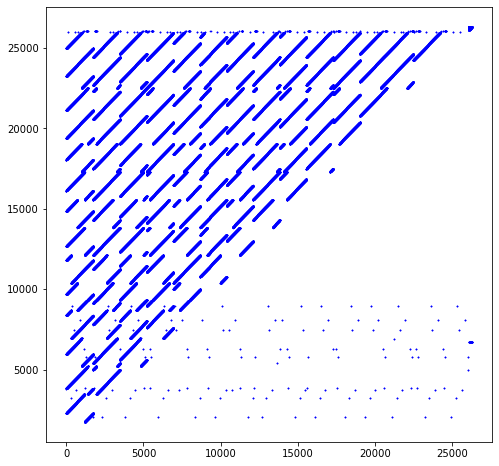

In [49]:
f, ax = plt.subplots(figsize=(8, 8))

condm3 = test3["magic3"] == 1

plt.scatter(test['FirstId' ].loc[condm3],
            test['SecondId'].loc[condm3], s=0.5, c="blue")

plt.show()

In [50]:
submission_bonus = pd.DataFrame(
    {
        "pairId": test.pairId,
        "Prediction": test3["magic3"].astype(int),
    })

assert(submission_bonus.shape[0] == test.shape[0])
assert(submission_bonus.Prediction.dtype == 'int')

print("magic vs magic3", np.sqrt(np.mean(pred.astype('int')-test3["magic3"].astype('int'))**2))

submission_bonus.to_csv('submission_bonus2.csv', index=False)

magic vs magic3 0.0037661104327770993


In [51]:
# got 0.994682